# Topics Extraction from Conferences Speeches

In [51]:
import pandas as pd
import nltk
import gensim
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from textblob import TextBlob
from textblob import Word

from textblob import TextBlob
sw = nltk.corpus.stopwords.words('english')

from nltk.stem import PorterStemmer
st = PorterStemmer()

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from gensim import corpora, models, similarities

import pyLDAvis.gensim
import warnings


In [52]:
# Loading Data
data = pd.read_csv('./data/cleaned_data.csv')

In [53]:
data.head()

,speaker,conf_number,transcript,summarized_token,totalwords,summarized_bart
0,boris_johnson,5.txt,wish could tell pandemic were going over wish ...,end year hitting per cent potential revolution...,4270.0,even pandemic began uk unbalanced economy almo...
1,boris_johnson,4.txt,thank you mr president excellencies ladies gen...,digital authoritarianism alas stuff dystopian ...,2125.0,internet things reshaping future every member ...
2,boris_johnson,3.txt,mr speaker thank much permission make statemen...,also using testing house knows help schools un...,1713.0,mr speaker thank much permission make statemen...
3,boris_johnson,2.txt,many many reasons me say come exeter college o...,theyll give anyone left school without alevel ...,2374.0,pm visiting exeter college outstanding educati...
4,boris_johnson,1.txt,thank you may seem bit premature make speech b...,end build build build build back better build ...,3797.0,may seem bit premature make speech britain cov...


## Feature Engineering

### Count Vectors

Since algorithms cannot understand simple text, it is required that the text must be converted into numerical data. To obtain the relevant features from transcripts, the Bag of words (Count Vectorization) technique was implemented.

In [54]:
# Count Vectors

cv = CountVectorizer()
cv.fit(data['transcript'])
cv_features = cv.transform(data['transcript'])

### Evaluate Features (from techniques above)

In [55]:
# defining the k numbers of clusters

def evaluate_number_cluster(matrix, matrix_name):
    
    '''
    Args: Receives the matrix of features (numerical data/count vectors)
    Function: Displays the Silhouette Coefficient  and the Elbow visualization to determine how man clusters will be used
    Return: Nothing
    '''
    print("Silhouette Coefficient - {} ".format(matrix_name))
    for n_cluster in range(2, 10):
        kmeans = KMeans(n_init=n_cluster, n_clusters=n_cluster).fit(matrix)
        label = kmeans.labels_
        sil_coeff = silhouette_score(matrix, label, metric='euclidean')
        print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

    elbow_method = {}
    for k in range(1, 10):
        kmeans_elbow = KMeans(n_init=k, n_clusters=k).fit(matrix)
        elbow_method[k] = kmeans_elbow.inertia_

    plt.figure()
    plt.plot(list(elbow_method.keys()), list(elbow_method.values()))
    plt.xlabel("Number of cluster using {} Features".format(matrix_name))
    plt.show()

Silhouette Coefficient - Count Vectors 
For n_clusters=2, The Silhouette Coefficient is 0.4851391396347721
For n_clusters=3, The Silhouette Coefficient is 0.19314923151279853
For n_clusters=4, The Silhouette Coefficient is 0.18937159451710978
For n_clusters=5, The Silhouette Coefficient is 0.22744011741099085
For n_clusters=6, The Silhouette Coefficient is 0.2517172012458079
For n_clusters=7, The Silhouette Coefficient is 0.20193690517611593
For n_clusters=8, The Silhouette Coefficient is 0.1945631982471944
For n_clusters=9, The Silhouette Coefficient is 0.18685106673872037


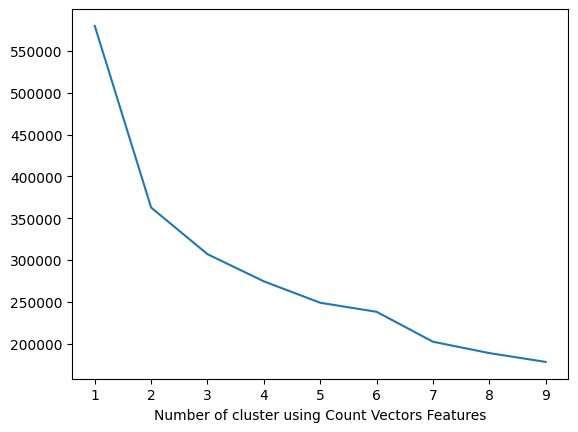

In [56]:
evaluate_number_cluster(cv_features, 'Count Vectors')

## Building Clustering Model 

A k-means algorithm will be implemented to group data.

In [57]:
n_cluster = 2
transcript = data['transcript'].to_list()
features = cv_features

segments = KMeans(n_init='auto', n_clusters=n_cluster)
segments.fit(features)

#segment outputs
output = segments.labels_.tolist()
segmentation =  {'transcript': transcript, 'cluster': output}
output_df = pd.DataFrame(segmentation)

#talks per segment
output_df['cluster'] = segments.labels_.tolist()
output_df['cluster'].value_counts()


cluster
1    37
0     5
Name: count, dtype: int64

In [58]:
cluster_1 = output_df[output_df.cluster == 0]
cluster_2 = output_df[output_df.cluster == 1]

### Cluster Visualization

To gain a deeper understanding of the content within each cluster, I will utilize word cloud monograms, which visually represent the most frequent and relevant words in each cluster.

#### Cluster 1

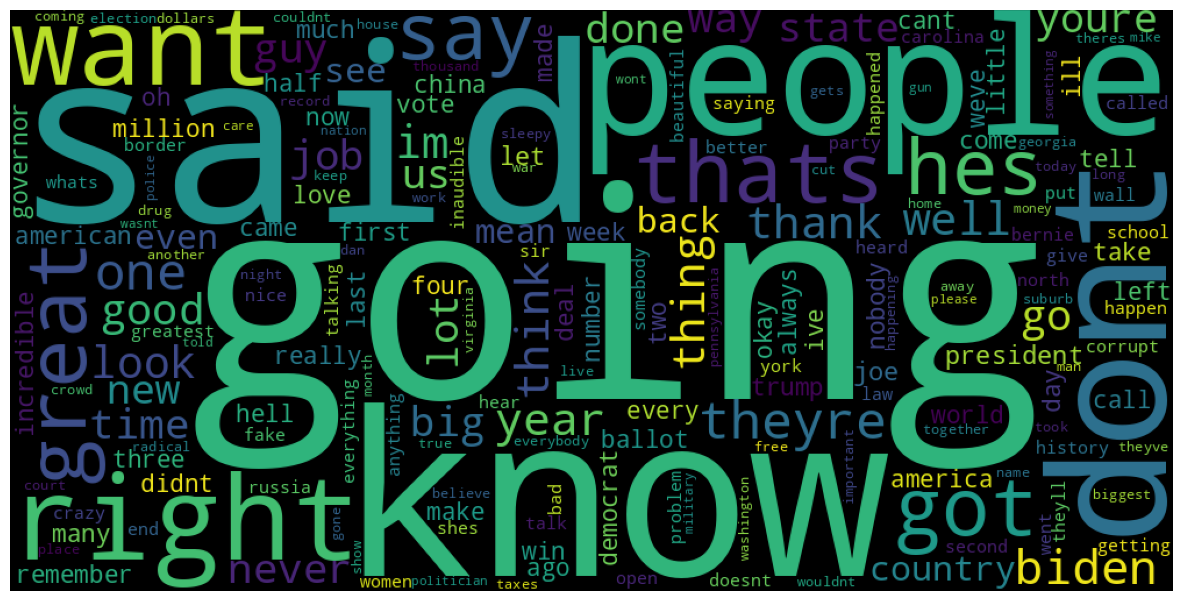

In [59]:
# cluster 1 visualization

# Mono Gram
wordcloud = WordCloud(width = 1000, height = 500, collocations = False).generate_from_text(' '.join(cluster_1['transcript']))

# Generate plot
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Cluster 2

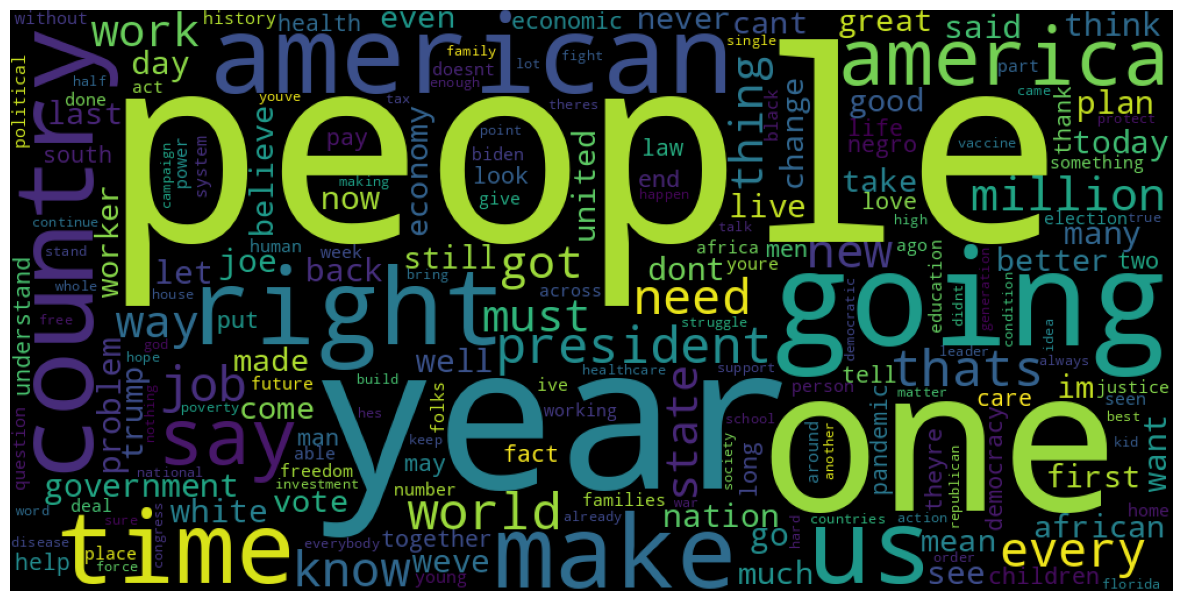

In [60]:

wordcloud = WordCloud(width = 1000, height = 500,collocations = False).generate_from_text(' '.join(cluster_2['transcript']))

# Generate plot
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Topic Modeling

In [61]:
def process(doc):
    toks = [w for s in nltk.sent_tokenize(doc) for w in nltk.word_tokenize(s)]
    filt_toks = []
    for i in toks:
        if re.search('[a-zA-Z]', i):
            filt_toks.append(i)
    post_process = [st.stem(t) for t in filt_toks]
    return post_process

### Topic Modeling for Cluster 1

In [62]:
toks = [process(a) for a in cluster_1.transcript]
conferences = [[x for x in y if x not in sw] for y in toks]


dictionary = corpora.Dictionary(conferences)
doc = [dictionary.doc2bow(text) for text in conferences]

# topic modeling
tm = models.LdaModel(doc, num_topics=5, id2word=dictionary)

twords={}
for topic, word in tm.show_topics():
    twords[topic]=re.sub('[^A-Za-z ]+', '', word)


for k, value in twords.items():
    print(f"------ Topic {k} ------")
    print(value, end="\n\n")

------ Topic 0 ------
go  said  know  want  right  dont  peopl  like  great  say

------ Topic 1 ------
go  said  want  peopl  say  great  get  know  got  right

------ Topic 2 ------
go  right  peopl  dont  theyr  said  say  great  one  want

------ Topic 3 ------
go  know  said  dont  peopl  get  want  say  like  right

------ Topic 4 ------
go  know  said  dont  like  right  want  get  peopl  got



In [63]:
pyLDAvis.enable_notebook()

warnings.filterwarnings("ignore", category=DeprecationWarning)
pyLDAvis.gensim.prepare(tm, doc, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.002922 -0.000116       1        1  35.441499
1     -0.003620 -0.004559       2        1  23.521214
4      0.002690  0.002481       3        1  21.276809
3      0.002357 -0.001983       4        1  19.755953
2     -0.004349  0.004177       5        1   0.004526, topic_info=       Term        Freq       Total Category  logprob  loglift
384      go  437.000000  437.000000  Default  30.0000  30.0000
818   right  217.000000  217.000000  Default  29.0000  29.0000
705   peopl  226.000000  226.000000  Default  28.0000  28.0000
259    dont  222.000000  222.000000  Default  27.0000  27.0000
834    said  297.000000  297.000000  Default  26.0000  26.0000
...     ...         ...         ...      ...      ...      ...
555    like    0.005997  212.448003   Topic5  -5.1399  -0.4720
381     get    0.005826  205.888757   Topic5  -5.1688  -0.4695
1110   year    0.004253  130.546318   Topic5  -5.4835  -0.3287
300    even    0.003710   88.717774   Topic5  -5.6200  -0.0789
1064   well    0.003863  124.007862   Topic5  -5.5797  -0.3735

[426 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
1901      1  0.379987      afghanistan
1901      2  0.379987      afghanistan
1901      3  0.379987      afghanistan
1902      1  0.597039  africanamerican
38        1  0.381786            amend
...     ...       ...              ...
1588      2  0.188575              yet
1588      3  0.377149              yet
1588      4  0.188575              yet
1589      1  0.365534              yoe
1589      3  0.365534              yoe

[934 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 5, 4, 3])

### Topic Modeling for Cluster 2

In [64]:
toks = [process(a) for a in cluster_2.transcript]
conferences = [[x for x in y if x not in sw] for y in toks]

#dictionary from text
dictionary = corpora.Dictionary(conferences)

doc = [dictionary.doc2bow(text) for text in conferences]

#topic modeling
tm = models.LdaModel(doc, num_topics=5, id2word=dictionary)
tm.show_topics()

twords={}
for topic, word in tm.show_topics():
    twords[topic]=re.sub('[^A-Za-z ]+', '', word)


for k, value in twords.items():
    print(f"------ Topic {k} ------")
    print(value, end="\n\n")

------ Topic 0 ------
peopl  countri  go  year  make  us  right  one  time  get

------ Topic 1 ------
peopl  get  one  us  american  go  make  year  countri  work

------ Topic 2 ------
go  peopl  make  right  countri  america  presid  one  get  vote

------ Topic 3 ------
peopl  one  go  us  work  make  say  right  countri  america

------ Topic 4 ------
peopl  american  go  say  america  year  countri  work  one  get



In [65]:
pyLDAvis.enable_notebook()

warnings.filterwarnings("ignore", category=DeprecationWarning)
pyLDAvis.gensim.prepare(tm, doc, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.006698  0.003034       1        1  36.056498
4     -0.001988 -0.004002       2        1  25.541425
3     -0.002806 -0.001001       3        1  19.839000
2     -0.005000  0.004592       4        1  10.012392
1      0.003097 -0.002622       5        1   8.550685, topic_info=         Term        Freq       Total Category  logprob  loglift
341        go  602.000000  602.000000  Default  30.0000  30.0000
589     peopl  870.000000  870.000000  Default  29.0000  29.0000
332       get  387.000000  387.000000  Default  28.0000  28.0000
500      make  434.000000  434.000000  Default  27.0000  27.0000
568       one  417.000000  417.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
710       say   22.837745  386.939432   Topic5  -5.6654  -0.3707
483      live   20.233260  276.719009   Topic5  -5.7865  -0.1565
550       new   19.126136  240.865527   Topic5  -5.8428  -0.0740
545      need   20.163185  297.070468   Topic5  -5.7900  -0.2310
2110  america   19.940398  334.322570   Topic5  -5.8011  -0.3602

[457 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
2         1  0.318162   abl
2         2  0.159081   abl
2         3  0.307557   abl
2         4  0.116659   abl
2         5  0.095449   abl
...     ...       ...   ...
1808      1  0.464968  youv
1808      2  0.209986  youv
1808      3  0.179988  youv
1808      4  0.074995  youv
1808      5  0.059996  youv

[1232 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 4, 3, 2])